# Data Illustration

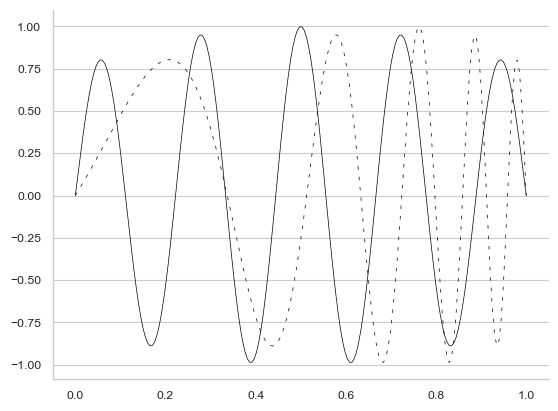

In [2]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

# sns.set_theme()
sns.set_style("whitegrid")
sns.set_context("paper")

np.random.seed(43)

N = 10000
p = 10
alpha = np.random.randn()
beta = np.random.randn(p)

t = np.linspace(0,1,1000)
def m(x):
    eta = 2*(x-0.5).dot(beta)/np.sqrt(p) + alpha
    k = 4
    a = 3 * stats.logistic.cdf(eta) - 1.5
    gam_t = (np.exp(k*(a * t)) - 1) / (np.exp(k*a) - 1)
    return (1 - np.power(gam_t - 0.5, 2)) * np.sin(np.pi * 9 * gam_t)
    # return gam_t

# for i in range(15):
#     sns.lineplot(x=t, y=m(np.random.randn(p)), color='black', alpha=1, linewidth=0.5)

t = np.linspace(0,1,200)
template = (1 - np.power(t - 0.5, 2)) * np.sin(np.pi * 9 * t)
plt.plot(t, template, color='black', linewidth=0.5)

plt.plot(t, m(np.random.rand(p)), color='black', linestyle=(0, (5, 10)), linewidth=0.5)

plt.gca().spines[['right', 'top']].set_visible(False)
plt.grid(axis='x')
plt.savefig('../plots/sample_phase.pdf')

# Simulation results

In [ ]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import seaborn as sns
import json

OUT_FILE = 'benchmark_results/phase_benchmark_out.json'

with open(OUT_FILE, 'r') as f:
    results = json.load(f)

df = pd.DataFrame(results, columns=['method', 'N', 'p', 'duration', 'dist_duration', 'err'])
df['group'] ='p=' + df['p'].astype(str) +  ', N=' + df['N'].astype(str)
df['fitting_duration'] = df['duration'] - df['dist_duration']
# sns.boxplot(df, y='duration', x='method')

In [ ]:
from plot_bench import *
forest_df = make_forest_df(df)
plot_forest_df(forest_df)
plt.savefig("../plots/runtime_phase.pdf")

In [ ]:
from plot_bench import *
plot_errors(df[df.N != 50])
plt.savefig("../plots/error_phase.pdf")

In [ ]:


def make_legend(df, expand=[-5,-5,5,5]):
    df = df.copy().rename(columns={ 'err': 'MSE' })
    df['Method'] = df.method.map({'cart_2means': 'RFWLCFR', 'medoid_greedy': 'MRF' })
    sns.set_style("whitegrid")
    sns.set_context("paper", rc={
        "axes.labelsize": 20,
        "xtick.labelsize": 20
    })
    grid = sns.catplot(df,
        x='N', y='MSE',
        col="p",
        hue="Method",
        kind='box', hue_order=['MRF', 'RFWLCFR'])

    legend = plt.legend()
    fig = legend.figure
    fig.canvas.draw()
    bbox = legend.get_window_extent()
    bbox = bbox.from_extents(*(bbox.extents + np.array(expand)))
    bbox = bbox.transformed(fig.dpi_scale_trans.inverted())

    legend_fig, legend_ax = plt.subplots(figsize=(bbox.width, bbox.height))
    legend_squared = legend_ax.legend(
        *grid.axes[0][0].get_legend_handles_labels(), 
        bbox_to_anchor=(0, 0, 1, 1),
        bbox_transform=legend_fig.transFigure,
        frameon=False,
        fancybox=None,
        shadow=False,
        ncol=1,
        mode='expand',
    )
    legend_ax.axis('off')
    legend_fig.savefig(
        './plots/legend.pdf',
        bbox_inches='tight',
        bbox_extra_artists=[legend_squared],)


make_legend(df)
